# ---------> **GESTURE RECOGNITION SYSTEM PROJECT** <---------

# Step 1: Data Load and Read

In [1]:
import pandas as pd

# Load datasets
train_df = pd.read_csv(r"D:\# DATA SCIENCE\# PROJECTS\- PROJECTS INTERNSHIPS\CODECLAUSE -AI ENGINEERING\Gesture Recognition System Project\Data\sign_mnist_train.csv")
test_df = pd.read_csv(r"D:\# DATA SCIENCE\# PROJECTS\- PROJECTS INTERNSHIPS\CODECLAUSE -AI ENGINEERING\Gesture Recognition System Project\Data\sign_mnist_test.csv")

# Print data head
print("Training Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())

# Separate features and labels
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values
test_labels = test_df['label'].values
test_images = test_df.drop('label', axis=1).values


Training Data Head:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       20

# Step 2: Data Preparation and Preprocessing

In [2]:
import numpy as np

# Normalize and reshape data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

# Transformations for PyTorch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Mapping from numerical labels (0-24) to corresponding letters (A-Z)
label_to_letter = {i: chr(65 + i) for i in range(25)}  # 0 -> 'A', 1 -> 'B', ..., 24 -> 'Y'


# Step 3: Exploratory Data Analysis

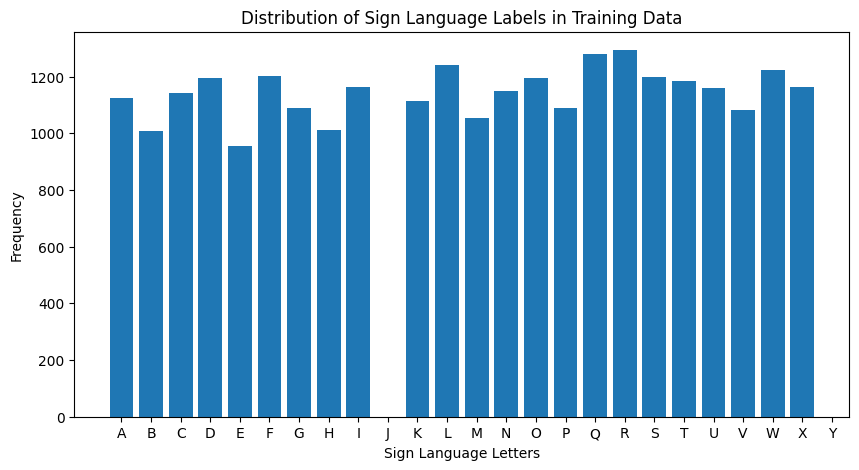

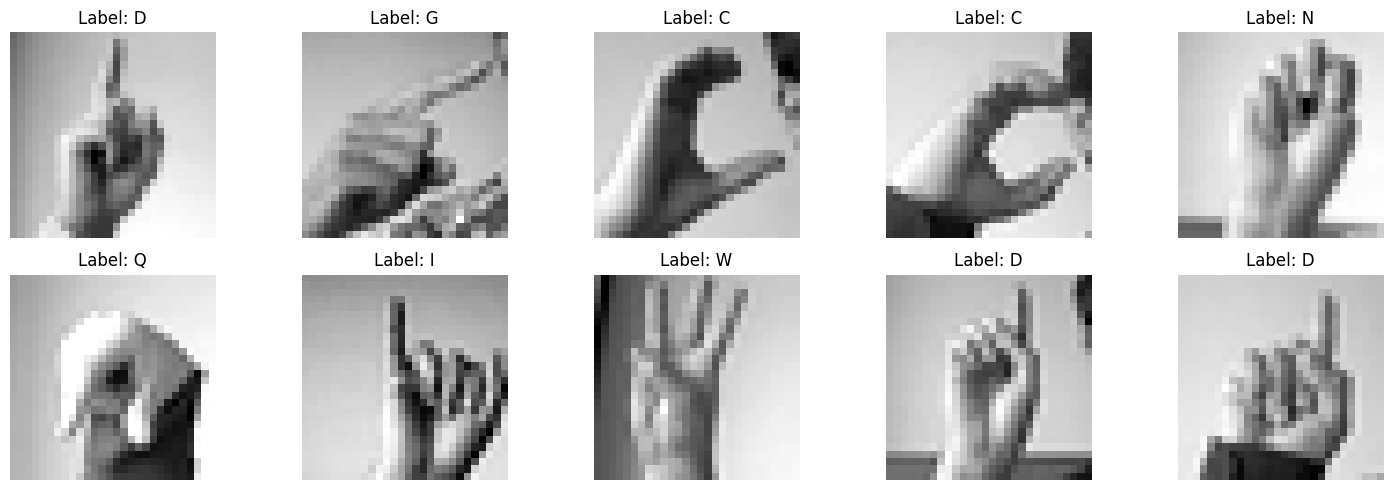

In [3]:
# Visualization: Distribution of Labels
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=np.arange(25) - 0.5, rwidth=0.8)
plt.xticks(range(25), [chr(65 + i) for i in range(25)])  # Labeling 0-24 as A-Y
plt.title('Distribution of Sign Language Labels in Training Data')
plt.xlabel('Sign Language Letters')
plt.ylabel('Frequency')
plt.show()

# Display a few sample images from the dataset
def display_samples(images, labels, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')  # Adjust reshape as needed
        plt.title(f'Label: {chr(65 + labels[i])}')  # Convert label to letter
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display samples
display_samples(train_images, train_labels)

# Step 4: Create Dataset Class

In [4]:
import torch
from torch.utils.data import Dataset

class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.astype(np.float32)  # Ensure images are float32
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Step 5: Create Datasets and Data Loaders

In [5]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = SignLanguageDataset(train_images, train_labels, transform=transform)
test_dataset = SignLanguageDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Step 6: Build the CNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# Build the CNN model
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 25)  # 25 outputs (A-Y)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Step 7: Initialize Model, Loss Function, and Optimizer

In [7]:
import torch.optim as optim

# Initialize the model, loss function, and optimizer
model = SignLanguageModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SignLanguageModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=25, bias=True)
)

# Step 8: Model Training

In [8]:
# Training loop
for epoch in range(50):  # Number of epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')


Epoch 1, Loss: 1.238503546773137
Epoch 2, Loss: 0.2647558772341633
Epoch 3, Loss: 0.140977624126456
Epoch 4, Loss: 0.09492899206117456
Epoch 5, Loss: 0.07161547139174107
Epoch 6, Loss: 0.05939710102345803
Epoch 7, Loss: 0.05084297860080337
Epoch 8, Loss: 0.0428372129644886
Epoch 9, Loss: 0.040567423703283555
Epoch 10, Loss: 0.042416346569584644
Epoch 11, Loss: 0.03531208626995415
Epoch 12, Loss: 0.032248353020348834
Epoch 13, Loss: 0.027178129672638895
Epoch 14, Loss: 0.03169639304167393
Epoch 15, Loss: 0.02650927905767227
Epoch 16, Loss: 0.025758119538944163
Epoch 17, Loss: 0.023617698061045224
Epoch 18, Loss: 0.022056331971587937
Epoch 19, Loss: 0.022500032192491762
Epoch 20, Loss: 0.021815984775415364
Epoch 21, Loss: 0.018370946501287715
Epoch 22, Loss: 0.016671366535424916
Epoch 23, Loss: 0.018542646163045594
Epoch 24, Loss: 0.018770270760186277
Epoch 25, Loss: 0.016443284641698138
Epoch 26, Loss: 0.014419470774345636
Epoch 27, Loss: 0.014021325447704612
Epoch 28, Loss: 0.015037098

# Step 9: Model Evaluation

In [9]:
# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total}%')


Test Accuracy: 95.0223089793642%


# Step 10: Preprocess Frame Function

In [14]:
import cv2

# Preprocess frame function
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (28, 28))
    normalized = resized / 255.0
    reshaped = np.reshape(normalized.astype(np.float32), (1, 1, 28, 28))  # Ensure reshaped is float32
    tensor = torch.tensor(reshaped).to(device)  # Use default dtype float32 for tensor creation.
    return tensor


# Step 11: Open Webcam and Predict Gesture

In [27]:
# Open webcam
cap = cv2.VideoCapture(0)

# Create a named window with the flag for full-screen
cv2.namedWindow('Gesture Recognition', cv2.WND_PROP_FULLSCREEN)
cv2.setWindowProperty('Gesture Recognition', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    processed_frame = preprocess_frame(frame)

    # Predict gesture
    with torch.no_grad():
        prediction = model(processed_frame)
        gesture_index = torch.argmax(prediction).item()

    # Convert the predicted index to a letter
    gesture_letter = label_to_letter[gesture_index]

    # Display the result
    cv2.putText(frame, f'Gesture: {gesture_letter}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (255, 0, 0), 2, cv2.LINE_AA)
    
    cv2.imshow('Gesture Recognition', frame)

    # Exit loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()